# Project Description 

This project aims to create a pipeline for image processing to detect lane lines based on camera images 

In [161]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import cv2
import pickle
import glob

plt.rcParams["figure.figsize"] = [15,9]


## 1. Camera Calibration 
This part of the code serves as the pipeline for the camera calibration to correct distortion 

In [146]:
# prepare object and image points for undistortion 
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

#        # Draw and display the corners
#        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#        cv2.imshow('img',img)
#        cv2.waitKey(500)
#cv2.destroyAllWindows()





In [147]:
#Function definition for undistortion 
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
    imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    return undist

In [148]:
#apply undistort on one of the images
img = cv2.imread('camera_cal/calibration1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
cv2.imwrite('camera_cal/calibration1_undistorted.jpg', undistorted)


True

## 2. Perspective Transform

This section of code adds the perspective transform to unwarp the lane line images. The main function of code performing the unwarp is in the unwarp function definition, while the parameters are fine-tuned in src and dst lists 2 kernels below

In [149]:
def unwarp(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

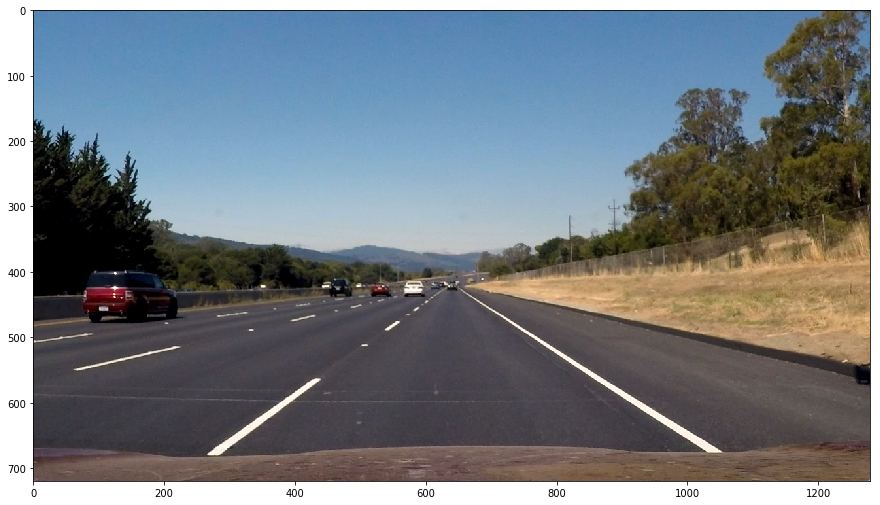

In [162]:
image = plt.imread('test_images/straight_lines2.jpg')
plt.imshow(image, cmap='RdBu')

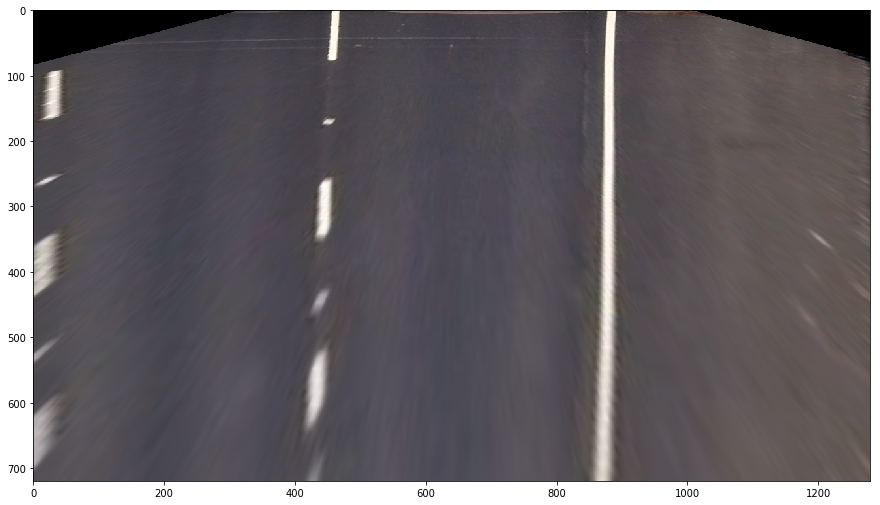

In [213]:
h = image.shape[0]
w = image.shape[1]
y = 450
src = np.float32([(250, 680), (600, 450), (950, 680), (680, 450)])
dst = np.float32([(y, 0), (y, h), (w-y, 0), (w-y, h)])

image_unwarp = unwarp(image, src, dst)
plt.imshow(image_unwarp, cmap='RdBu')


# 3. Applying the Sobel Operator and Gradient Operations  
This section of code explores different types of color channels which would produce the most distinct results for identifying a lane


In [119]:
test_image_names =  ['test_images/straight_lines1.jpg', 
               'test_images/straight_lines2.jpg',
               'test_images/test1.jpg',
               'test_images/test2.jpg', 
               'test_images/test3.jpg', 
               'test_images/test4.jpg',
               'test_images/test5.jpg', 
               'test_images/test6.jpg']
test_images = [] 
for i in range(len(test_image_names)):
    curr = cv2.imread(test_image_names[i])
    test_images.append(curr)


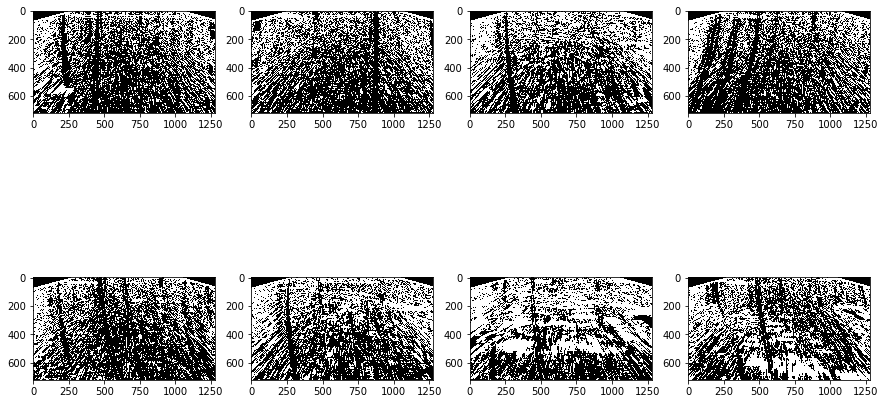

In [214]:
#Check Sobel operator
fig = plt.figure() 
thresh=(np.pi/4, np.pi/2)
sobel_kernel=15

for i in range(len(test_images)): 
    
    pic = cal_undistort(test_images[i], objpoints, imgpoints)
    pic = unwarp(pic, src, dst)
    gray = cv2.cvtColor(pic,cv2.COLOR_RGB2GRAY)
    
    #Take the (absolute) gradient in x and y separately
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    #Calculate the direction of the gradient 
    grad = np.arctan2(abs_sobely, abs_sobelx)
    binary = np.zeros_like(grad)
    binary[(grad >= thresh[0])] = 1

   #binary[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    
    fig.add_subplot(2,4, i+1)
    plt.imshow(binary, cmap='gray')


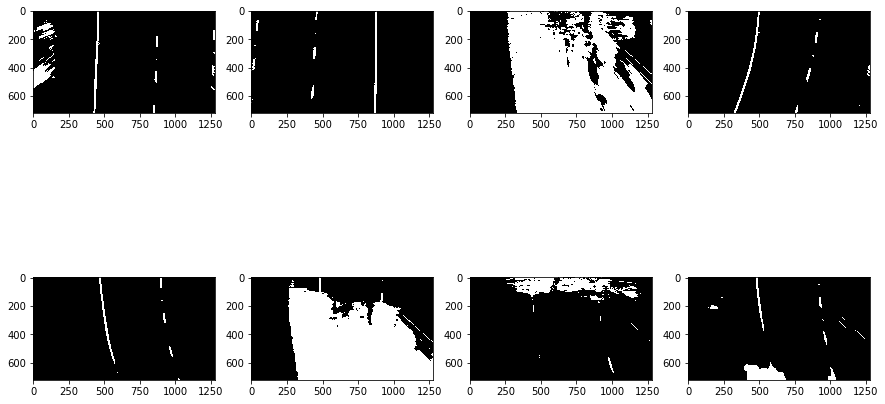

In [215]:
#Check RGB Colorspace 
fig = plt.figure()

thresh = (180, 255)

for i in range(len(test_images)):
    pic = cal_undistort(test_images[i], objpoints, imgpoints)
    pic = unwarp(pic, src, dst)
    R = pic[:,:,2]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    fig.add_subplot(2,4,i+1)

    plt.imshow(binary, cmap='gray')

    



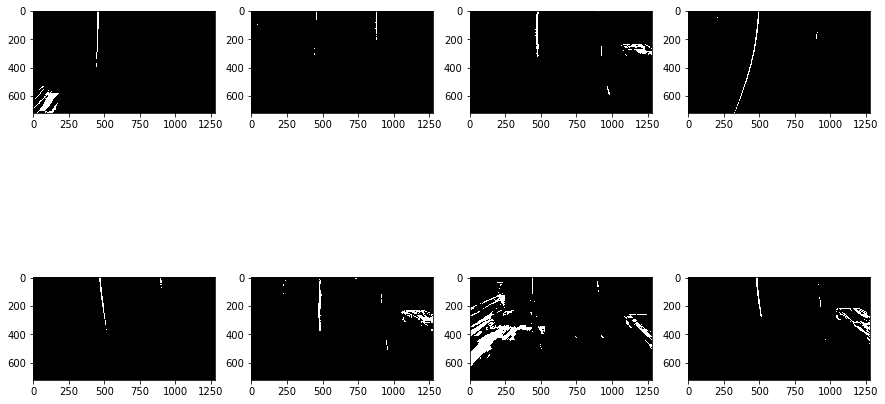

In [216]:
#Check Saturation threshold
fig = plt.figure()
threshold = (170, 255)

for i in range(len(test_images)):
    pic = cal_undistort(test_images[i], objpoints, imgpoints)
    pic = unwarp(pic, src, dst)
    hls = cv2.cvtColor(pic, cv2.COLOR_RGB2HLS)
    S = hls[:,:, 2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    fig.add_subplot(2,4,i+1)

    plt.imshow(binary, cmap='gray')

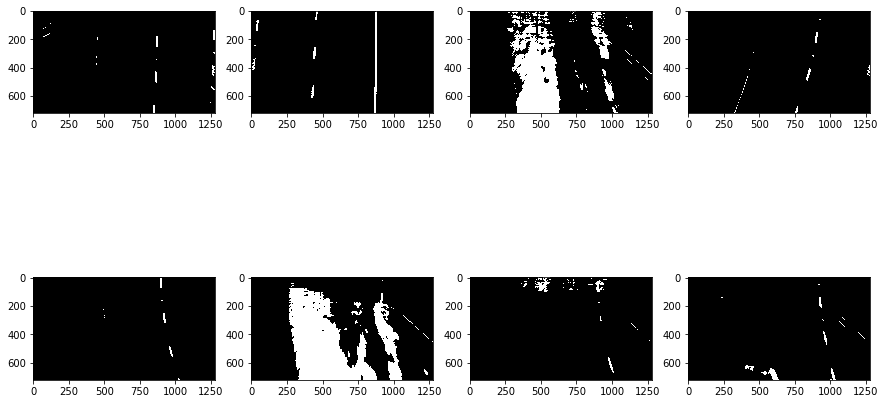

In [217]:
#Check Saturation threshold
fig = plt.figure()
threshold = (170, 255)

for i in range(len(test_images)):
    pic = cal_undistort(test_images[i], objpoints, imgpoints)
    pic = unwarp(pic, src, dst)
    hls = cv2.cvtColor(pic, cv2.COLOR_RGB2HLS)
    S = hls[:,:, 1]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    fig.add_subplot(2,4,i+1)

    plt.imshow(binary, cmap='gray')

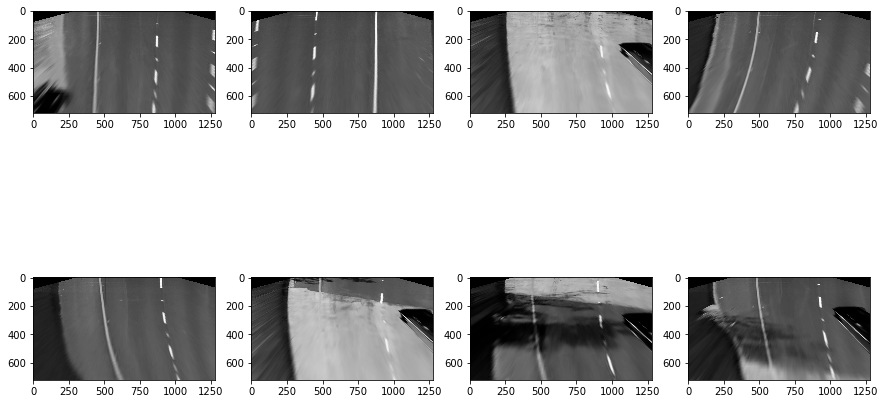

In [218]:
#Check grayscale colorspace
fig = plt.figure()

for i in range(len(test_images)):
    pic = cal_undistort(test_images[i], objpoints, imgpoints)
    pic = unwarp(pic, src, dst)
    gray = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
    fig.add_subplot(2,4,i+1)
    plt.imshow(gray, cmap='gray')


# Image pipeline
Function definition to return an image through the processing pipeline 

In [ ]:
def pipeline(image): 
    